## Introduction

This notebook will be used to share my analysis as to whether an SBA loan should be approved or denied based on the provided SBA loan data.

Because I'm using this for learning, this will be very detailed as I will be explaining my thought process at each step.

Why SBA Loan Approval?
My first job out of college was at a Product Based Company as Data Scientist Inten, where I spent my time understanding fanancial of small businesses. I loved being able to dig into the financial statements for each business and see how businesses in different industries operate. This role taught me the importance of small businesses and the role they play in our communities. It also taught me about some of the struggles entreprenuers face when starting a business, including the initial capital necessary to get started.

Small business owners often seek out SBA (Small Business Association) loans because they guarantee part of the loan. Without going into too much detail, this basically means that the SBA will cover some of the losses should the business default on the loan, which lowers the risk involved for the business owner(s). This increases the risk to the SBA however, which can sometimes make it difficult to get accepted for one of their loan programs. The SBA will play a particularly important role in small business success now with the COVID-19 pandemic which is impacting many small businesses around the world, crippling most of them. I thought it would be interesting to see if I could determine whether or not an SBA loan should be accepted or not given certain characteristics like the industry of the business, the size of the loan, amount of the loan that is guaranteed, etc.

In [1]:
# Import packages used for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import pickle
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("Loan_Data.csv")

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\2614545670.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Loan_Data.csv")


In [3]:
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [4]:
df.shape

(899164, 27)

In [5]:
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

I'm not concerned with ChgOffDate since we're focused on whether or not a loan gets charged off at all rather than when it happens, but the other columns could pose issues. Let's start by removing records from some of these columns with null values.

I decided to remove the rows entirely rather than imputing because we have a large number of records to work with, and it's hard to know what would be the best imputing method would be given the nature of the information (for example, I don't want to just assume whether the business was new or existing as this has the potential to be a very important feature for us to consider)

In [6]:
# Drop null values from specified columns
df.dropna(subset=['Name', 'City', 'State', 'BankState', 'NewExist','RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)
df.isnull().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           725369
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [7]:
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

Looks like we're going to need to make some changes here. I begin with the currency fields that are currently being read as objects rather than floats.

Let's see how they are being read right now.

In [8]:
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv
0,"$60,000.00",$0.00,$0.00,"$60,000.00","$48,000.00"
1,"$40,000.00",$0.00,$0.00,"$40,000.00","$32,000.00"
2,"$287,000.00",$0.00,$0.00,"$287,000.00","$215,250.00"
3,"$35,000.00",$0.00,$0.00,"$35,000.00","$28,000.00"
4,"$229,000.00",$0.00,$0.00,"$229,000.00","$229,000.00"


It looks like they're coming in as strings because the '$' sign and commas are included. I can't change the type to a float without removing those, so I make those edits here.

In [9]:
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\3396011353.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))


Next, I take a look at ApprovalFY which should be an integer but is coming up as an object type.

In [10]:
# Check the number of each data type in the field
df['ApprovalFY'].apply(type).value_counts()

ApprovalFY
<class 'int'>    759570
<class 'str'>    126670
Name: count, dtype: int64

In [11]:
df['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1982, 1983, 1973, 1984, 2007, 1985, 1986, 1987,
       2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010, 2011, 1992, 1993,
       2002, 2012, 2013, 1994, 2014, 1975, 1977, 1976, '2004', '1994',
       '1979', '1976', '1975', '1974', '1977', '1981', '1982', '1983',
       '1984', '1978', '1980', '1968', '1976A', '1969', '1995', '1970',
       '2005', '1996', '1971', 1996, 1971], dtype=object)

We have a mixture of integers and strings here, with one record including an 'A' as well. I clean these next.

In [12]:
# Create a function to apply formatting to the records of str type only
def clean_str(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x


df['ApprovalFY'] = df['ApprovalFY'].apply(clean_str).astype('int64')

Now I'll change the type of a few other columns as appropriate.

In [13]:
# Change the type of NewExist to an integer, Zip and UrbanRural to str (categorical) and all currency-related fields to float values
df = df.astype({'Zip': 'str', 'NewExist': 'int64', 'UrbanRural': 'str', 'DisbursementGross': 'float', 'BalanceGross': 'float',
                          'ChgOffPrinGr': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Check to see dtypes so far
df.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                   object
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist               int64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural            object
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

I want to address the NAICS codes next. These refer to the industry each business belongs to, where each additional number is like a more granular filter that pinpoints the specific type of business. We're only really concerned with the general industry for this analysis, so we use the first two digits of each business's NAICS code to determine this. Luckily, a list was provided of the industries corresponding to the first two numbers of the NAICS codes, so we can use this as a reference.

In [14]:
# Create a new column with the industry the NAICS code represents
# Selects only the first two numbers of the NAICS code
df['Industry'] = df['NAICS'].astype('str').apply(lambda x: x[:2])

# Maps the approprate industry to each record based on the first two digits of the NAICS code
df['Industry'] = df['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})

# Remove records where Industry is NaN (NAICS code was a 0)
df.dropna(subset=['Industry'], inplace=True)

Alright, so far so good. I take a look at FranchiseCode next. The code itself isn't important to me; I care more about whether or not a business is a franchise or not for this analysis. I create a flag field for this.

In [15]:
# Create flag column IsFranchise based on FranchiseCode column
df.loc[(df['FranchiseCode'] <= 1), 'IsFranchise'] = 0
df.loc[(df['FranchiseCode'] > 1), 'IsFranchise'] = 1

Next I look at some of the fields that are considered flags already but aren't necessarily in a useable format right now. These include the NewExist, RevLineCr, LowDoc, and MIS_Status fields.

In [16]:
# NewExist
# Makesure NewExist has only 1s and 2s; Remove records where NewExist isn't 1 or 2
df['NewExist'].unique()

array([2, 1, 0])

In [17]:
# Keep records where NewExist == 1 or 2
df = df[(df['NewExist'] == 1) | (df['NewExist'] == 2)]

# Create NewBusiness field where 0 = Existing business and 1 = New business; based on NewExist field
df.loc[(df['NewExist'] == 1), 'NewBusiness'] = 0
df.loc[(df['NewExist'] == 2), 'NewBusiness'] = 1

In [18]:
# RevLineCr and LowDoc
# Double check RevLineCr and LowDoc unique values
df['RevLineCr'].unique()

array(['N', 'Y', '0', 'T', '`', ',', '1', 'C', '2', 'R', '7', 'A', '-',
       'Q'], dtype=object)

In [19]:
df['LowDoc'].unique()

array(['Y', 'N', 'C', '1', 'S', 'R', 'A', '0'], dtype=object)

In [20]:
# Remove records where RevLineCr != 'Y' or 'N' and LowDoc != 'Y' or 'N'
df = df[(df['RevLineCr'] == 'Y') | (df['RevLineCr'] == 'N')]
df = df[(df['LowDoc'] == 'Y') | (df['LowDoc'] == 'N')]

# RevLineCr and LowDoc: 0 = No, 1 = Yes
df['RevLineCr'] = np.where(df['RevLineCr'] == 'N', 0, 1)
df['LowDoc'] = np.where(df['LowDoc'] == 'N', 0, 1)

# Check that it worked
print(df['RevLineCr'].unique())
print(df['LowDoc'].unique())

[0 1]
[1 0]


In [21]:
# MIS_Status
# Make Default target field based on MIS_Status where P I F = 0 and CHGOFF = 1 so we can see what features are prevalant in a defaulted loan
df['Default'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['Default'].value_counts()

Default
0    358558
1     98382
Name: count, dtype: int64

Now that the flag fields have been addressed, let's tackle the date fields.

In [22]:
# Convert ApprovalDate and DisbursementDate columns to datetime values
# ChgOffDate not changed to datetime since it is not of value and will be removed later
df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\2663052509.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)
C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\2663052509.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[['ApprovalDate', 'DisbursementDate']] = df[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)


One metric I thought of that would be interesting to see is the number of days it took from the approval of the loan to the actual disbursement of the funds. My hypothesis is that the timing at which the funds were received could have a negative relationship with a business's ability to repay a loan, whereas the longer it took to receive funds, the more difficult it would be to pay off the loan. In my experience as a Analyst, there were a number of businesses that needed loan funding urgently to help the business stay afloat. I'm sure this would vary by industry however.

In [23]:
# Create DaysToDisbursement column which calculates the number of days passed between DisbursementDate and ApprovalDate
df['DaysToDisbursement'] = df['DisbursementDate'] - df['ApprovalDate']

# Change DaysToDisbursement from a timedelta64 dtype to an int64 dtype
# Converts series to str, removes all characters after the space before 'd' in days for each record, then changes the dtype to int
df['DaysToDisbursement'] = df['DaysToDisbursement'].astype('str').apply(lambda x: x[:x.index('d') - 1]).astype('int64')

In [24]:
# Create DisbursementFY field for time selection criteria later
df['DisbursementFY'] = df['DisbursementDate'].map(lambda x: x.year)

Another metric I was interested in exploring is whether or not the bank servicing the loan was in the same state that the business was located. My assumption is that it would be more difficult to service a loan for a business in another state and that this could have a negative impact on a business's ability to repay the loan.

In [25]:
# Create StateSame flag field which identifies where the business State is the same as the BankState
df['StateSame'] = np.where(df['State'] == df['BankState'], 1, 0)

The next field I decided to create relates to the amount of the loan the SBA guaranteed. This is a unique feature SBA loans have where the SBA will 'guaranty' a percentage of the loan in the event of a loss. For example if a business took out a 500,000 loan and the SBA guaranteed 50%, if the business was unable to repay 200,000 of the loan the SBA would cover 100,000 of that loss. This makes these loans very attractive to small businesses because it mitigates their risk, but it also increases the risk for the SBA. This is why an analysis like this is important! These loans are typically guaranteed on a percentage basis rather than a specified dollar amount, so I create a field to represent this rather than the guaranteed amount provided in the original dataset.

In [26]:
# Create SBA_AppvPct field since the guaranteed amount is based on a percentage of the gross loan amount rather than dollar amount in most situations
df['SBA_AppvPct'] = df['SBA_Appv'] / df['GrAppv']

I wanted to look at whether the loan amount disbursed was equal to the full amount approved, so I added that feature as well.

In [27]:
# Create AppvDisbursed flag field signifying if the loan amount disbursed was equal to the full amount approved
df['AppvDisbursed'] = np.where(df['DisbursementGross'] == df['GrAppv'], 1, 0)

Now that we've done a lot of formatting to the data, let's make sure the data types are still correct.

In [28]:
df.dtypes


LoanNr_ChkDgt                  int64
Name                          object
City                          object
State                         object
Zip                           object
Bank                          object
BankState                     object
NAICS                          int64
ApprovalDate          datetime64[ns]
ApprovalFY                     int64
Term                           int64
NoEmp                          int64
NewExist                       int64
CreateJob                      int64
RetainedJob                    int64
FranchiseCode                  int64
UrbanRural                    object
RevLineCr                      int64
LowDoc                         int64
ChgOffDate                    object
DisbursementDate      datetime64[ns]
DisbursementGross            float64
BalanceGross                 float64
MIS_Status                    object
ChgOffPrinGr                 float64
GrAppv                       float64
SBA_Appv                     float64
I

In [29]:
# Format dtypes where necessary after feature engineering
df = df.astype({'IsFranchise': 'int64', 'NewBusiness': 'int64'})
df.dtypes

LoanNr_ChkDgt                  int64
Name                          object
City                          object
State                         object
Zip                           object
Bank                          object
BankState                     object
NAICS                          int64
ApprovalDate          datetime64[ns]
ApprovalFY                     int64
Term                           int64
NoEmp                          int64
NewExist                       int64
CreateJob                      int64
RetainedJob                    int64
FranchiseCode                  int64
UrbanRural                    object
RevLineCr                      int64
LowDoc                         int64
ChgOffDate                    object
DisbursementDate      datetime64[ns]
DisbursementGross            float64
BalanceGross                 float64
MIS_Status                    object
ChgOffPrinGr                 float64
GrAppv                       float64
SBA_Appv                     float64
I

Now that each field we care about appears to have the correct data type, we can remove the fields that won't provide much value to the analysis. These are as follows:

LoanNr_ChkDgt and Name - provides no value to the actual analysis.

City and Zip - each have a large number of unique values, and my assumption is that it is not likely either would have any particularly significant values.

Bank - Name of the bank shouldn't matter for analysis, however this could potentially be used when revisiting this analysis to determine the asset size of the bank servicing the loan.

ChgOffDate - only applies when a loan is charged off and isn't relevant to the analysis.

NAICS - replaced by Industry.

NewExist - replaced by NewBusiness flag field.

FranchiseCode - replaced by IsFranchise flag field.

ApprovalDate and DisbursementDate - hypothesis that DaysToDisbursement will be more valueable.

SBA_Appv - guaranteed amount is based on percentage of gross loan amount, not dollar amount typically.

MIS_Status - Default field replaces this as the target field.

In [30]:
df.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'NAICS', 'ApprovalDate', 'NewExist', 'FranchiseCode',
                      'ChgOffDate', 'DisbursementDate', 'BalanceGross', 'ChgOffPrinGr', 'SBA_Appv', 'MIS_Status'], inplace=True)

In [31]:
# Verify all null values are removed from data
df.isnull().sum()

State                 0
BankState             0
ApprovalFY            0
Term                  0
NoEmp                 0
CreateJob             0
RetainedJob           0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementGross     0
GrAppv                0
Industry              0
IsFranchise           0
NewBusiness           0
Default               0
DaysToDisbursement    0
DisbursementFY        0
StateSame             0
SBA_AppvPct           0
AppvDisbursed         0
dtype: int64

In [32]:
# Check the shape of the data as it stands
df.shape

(456940, 21)

The last couple of features I wanted to look at are whether a loan was backed by Real Estate, and whether a loan was active during the Great Recession (2007-2009). These were both mentioned in the document which describes the dataset and how it was used for educatoinal purposes, and I think they will be very important features to consider.

To determine whether a loan was backed by Real Estate, I made a flag that signifies if the loan term is >= 20 years, as real estate-backed loans are typically at least this long since the loan term is usually tied to the useful life of the assets used for collateral. Unfortunately there's no way to know this for sure since it is not included explicitely in the data.

For loans active during the Great Recession, I created a flag for loans where the Great Recession (2007-2009) between DisbursementFY and DisbursementFY plus the loan term (in years).

In [33]:
# Field for loans backed by Real Estate (loans with a term of at least 20 years)
df['RealEstate'] = np.where(df['Term'] >= 240, 1, 0)

# Field for loans active during the Great Recession (2007-2009)
df['GreatRecession'] = np.where(((2007 <= df['DisbursementFY']) & (df['DisbursementFY'] <= 2009)) | 
                                     ((df['DisbursementFY'] < 2007) & (df['DisbursementFY'] + (df['Term']/12) >= 2007)), 1, 0)

When it comes to the time period for the records used in the analysis and modeling later, I think the document provided with the dataset had good rationale. This rationale is listed in the 3.3 Time Period section of the document, but to summarize, the emphasis was placed on default rates of loans disbursed through 2010. They wanted to account for the Great Recession and restrict the time frame to loans by excluding those disbursed after 2010 since the loan term is typically 5 years or more.

I wanted to adopt this for my analysis as well, so I set a selection criteria for loans with a disbursement date prior to 2010.

In [34]:
# Select only records with a disbursement year through 2010
df = df[df['DisbursementFY'] <= 2010]

# Check how many records remain
df.shape

(438504, 23)

# Data Analysis
Let's take a break now that we have done some data cleaning and formatting to see what we're dealing with now.

In [35]:
df.describe(include=['object', 'float', 'int'])

,State,BankState,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,Industry,IsFranchise,NewBusiness,Default,DaysToDisbursement,DisbursementFY,StateSame,SBA_AppvPct,AppvDisbursed,RealEstate,GreatRecession
count,438504,438504,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504,438504.000000,438504.000000,4.385040e+05,4.385040e+05,438504,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000,438504.000000
unique,51,53,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CA,NC,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,Retail_trade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,59171,55644,NaN,NaN,NaN,NaN,NaN,270482,NaN,NaN,NaN,NaN,78626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2002.665604,94.119445,9.794887,1.843611,4.568973,NaN,0.418959,0.057247,1.663462e+05,1.489304e+05,NaN,0.030597,0.263840,0.221918,109.090631,2002.705704,0.454094,0.654071,0.636478,0.111972,0.733934
std,NaN,NaN,5.492623,68.548785,57.674184,16.496650,15.330176,NaN,0.493389,0.232314,2.515612e+05,2.397083e+05,NaN,0.172224,0.440714,0.415537,182.221498,5.403909,0.497889,0.179932,0.481014,0.315332,0.441900
min,NaN,NaN,1984.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,4.000000e+03,1.000000e+03,NaN,0.000000,0.000000,0.000000,-3614.000000,1984.000000,0.000000,0.050000,0.000000,0.000000,0.000000
25%,NaN,NaN,1999.000000,58.000000,2.000000,0.000000,0.000000,NaN,0.000000,0.000000,3.499100e+04,2.500000e+04,NaN,0.000000,0.000000,0.000000,27.000000,2000.000000,0.000000,0.500000,0.000000,0.000000,0.000000
50%,NaN,NaN,2005.000000,84.000000,4.000000,0.000000,1.000000,NaN,0.000000,0.000000,7.500000e+04,5.000000e+04,NaN,0.000000,0.000000,0.000000,51.000000,2005.000000,0.000000,0.500000,1.000000,0.000000,1.000000
75%,NaN,NaN,2007.000000,90.000000,9.000000,1.000000,4.000000,NaN,1.000000,0.000000,1.880000e+05,1.510000e+05,NaN,0.000000,1.000000,0.000000,109.000000,2007.000000,1.000000,0.829994,1.000000,0.000000,1.000000


This shows some interesting information for the analysis, including:

    The average loan term is ~94 months with a standard deviation of ~69 months, suggesting the loan terms are pretty spread out; Max loan term of 527 months could suggest some outliers in the data

    The average number of employees is about 9.8 with 75% of of businesses having 9 or less employees, suggesting NoEmp is very left skewed; Similar situations for created and retained jobs

    The mean for flag fields essentially shows a percentage, so roughly 42% of loans in the sample are revolving lines of credit and about 6% of loans were a part of the Low Doc program

    Average gross loan disbursement was ~166,000 with 75% of loans being less than 188,000, suggesting left skewness again

    About 77.8% of loans in the sample were paid in full

    Only 3% of businesses were franchised; About 26% of loan applicants were considered new businesses.

    The average days to loan disbursement was 109; The min was -3,614, suggesting at least one error in the data (since that's ~301 years)

    Approximately 45.4% of loans were serviced by banks in the same state as the applying business

    The average percentage of SBA loan guaranteed amount was 65.4%

    About 11.2% of the loans backed by real estate per my assumptions

    About 73.4% of the loans in the sample were active at some point during the Great Recession

After reviewing these details, there are a few more things I want to add to aid in this analysis. One of these things is to create a flag that signifies if the disbursed amount was greater than what was actually approved. I think this would have interesting implications because the disbursement of extra funds could suggest that the business was at greater risk of default. This could be correlated to revolving lines of credit where the business continually draws and pays down a balance however.

In [36]:
# Create flag to signify if a larger amount was disbursed than what the Bank had approved
# Likely RevLineCr?
df['DisbursedGreaterAppv'] = np.where(df['DisbursementGross'] > df['GrAppv'], 1, 0)

I also wanted to remove records with a negative DaysToDisbursement under the assumption that loan funds would not be disbursed until they were approved.

In [37]:
# Remove records with loans disbursed prior to being approved
df = df[df['DaysToDisbursement'] >= 0]

# Check how many records are left
df.shape

(438090, 24)

In [38]:
df.describe(include=['object', 'float', 'int'])

,State,BankState,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,Industry,IsFranchise,NewBusiness,Default,DaysToDisbursement,DisbursementFY,StateSame,SBA_AppvPct,AppvDisbursed,RealEstate,GreatRecession,DisbursedGreaterAppv
count,438090,438090,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090,438090.000000,438090.000000,4.380900e+05,4.380900e+05,438090,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000,438090.000000
unique,51,53,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,CA,NC,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,Retail_trade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,59121,55628,NaN,NaN,NaN,NaN,NaN,270261,NaN,NaN,NaN,NaN,78554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2002.662987,94.113178,9.795026,1.843525,4.567514,NaN,0.419122,0.057189,1.663169e+05,1.488998e+05,NaN,0.030610,0.263825,0.222039,109.220368,2002.703264,0.453993,0.654037,0.636351,0.111979,0.734509,0.314639
std,NaN,NaN,5.490509,68.545279,57.699074,16.503378,15.332166,NaN,0.493416,0.232204,2.515088e+05,2.396534e+05,NaN,0.172259,0.440706,0.415618,182.165509,5.401641,0.497879,0.179937,0.481050,0.315341,0.441595,0.464372
min,NaN,NaN,1984.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,4.000000e+03,1.000000e+03,NaN,0.000000,0.000000,0.000000,0.000000,1984.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1999.000000,58.000000,2.000000,0.000000,0.000000,NaN,0.000000,0.000000,3.498000e+04,2.500000e+04,NaN,0.000000,0.000000,0.000000,27.000000,2000.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,2005.000000,84.000000,4.000000,0.000000,1.000000,NaN,0.000000,0.000000,7.500000e+04,5.000000e+04,NaN,0.000000,0.000000,0.000000,51.000000,2005.000000,0.000000,0.500000,1.000000,0.000000,1.000000,0.000000
75%,NaN,NaN,2007.000000,90.000000,9.000000,1.000000,4.000000,NaN,1.000000,0.000000,1.880000e+05,1.510000e+05,NaN,0.000000,1.000000,0.000000,109.000000,2007.000000,1.000000,0.829500,1.000000,0.000000,1.000000,1.000000


# Data Visualization

Although there are likely some potential outliers that could be explored, I want to start looking at the data from a new perspective. Before we go too far however, let's take a look at a correlation matrix to see the relationships among the features.

In [39]:
df.head()

,State,BankState,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementGross,GrAppv,Industry,IsFranchise,NewBusiness,Default,DaysToDisbursement,DisbursementFY,StateSame,SBA_AppvPct,AppvDisbursed,RealEstate,GreatRecession,DisbursedGreaterAppv
0,IN,OH,1997,84,4,0,0,0,0,1,60000.0,60000.0,Retail_trade,0,1,0,730,1999,0,0.80,1,0,0,0
1,IN,IN,1997,60,2,0,0,0,0,1,40000.0,40000.0,Accom/Food_serv,0,1,0,92,1997,1,0.80,1,0,0,0
2,IN,IN,1997,180,7,0,0,0,0,0,287000.0,287000.0,Healthcare/Social_assist,0,0,0,306,1997,1,0.75,1,0,1,0
5,CT,DE,1997,120,19,0,0,0,0,0,517000.0,517000.0,Manufacturing,0,0,0,122,1997,0,0.75,1,0,1,0
7,FL,AL,1997,84,1,0,0,0,0,1,45000.0,45000.0,Other_no_pub,0,1,0,487,1998,0,0.80,1,0,0,0


In [40]:
df.dtypes

State                    object
BankState                object
ApprovalFY                int64
Term                      int64
NoEmp                     int64
CreateJob                 int64
RetainedJob               int64
UrbanRural               object
RevLineCr                 int64
LowDoc                    int64
DisbursementGross       float64
GrAppv                  float64
Industry                 object
IsFranchise               int64
NewBusiness               int64
Default                   int64
DaysToDisbursement        int64
DisbursementFY            int64
StateSame                 int64
SBA_AppvPct             float64
AppvDisbursed             int64
RealEstate                int64
GreatRecession            int64
DisbursedGreaterAppv      int64
dtype: object

In [41]:
df['DisbursementGross'] = df['DisbursementGross'].astype('int64')
df['GrAppv'] = df['GrAppv'].astype('int64')

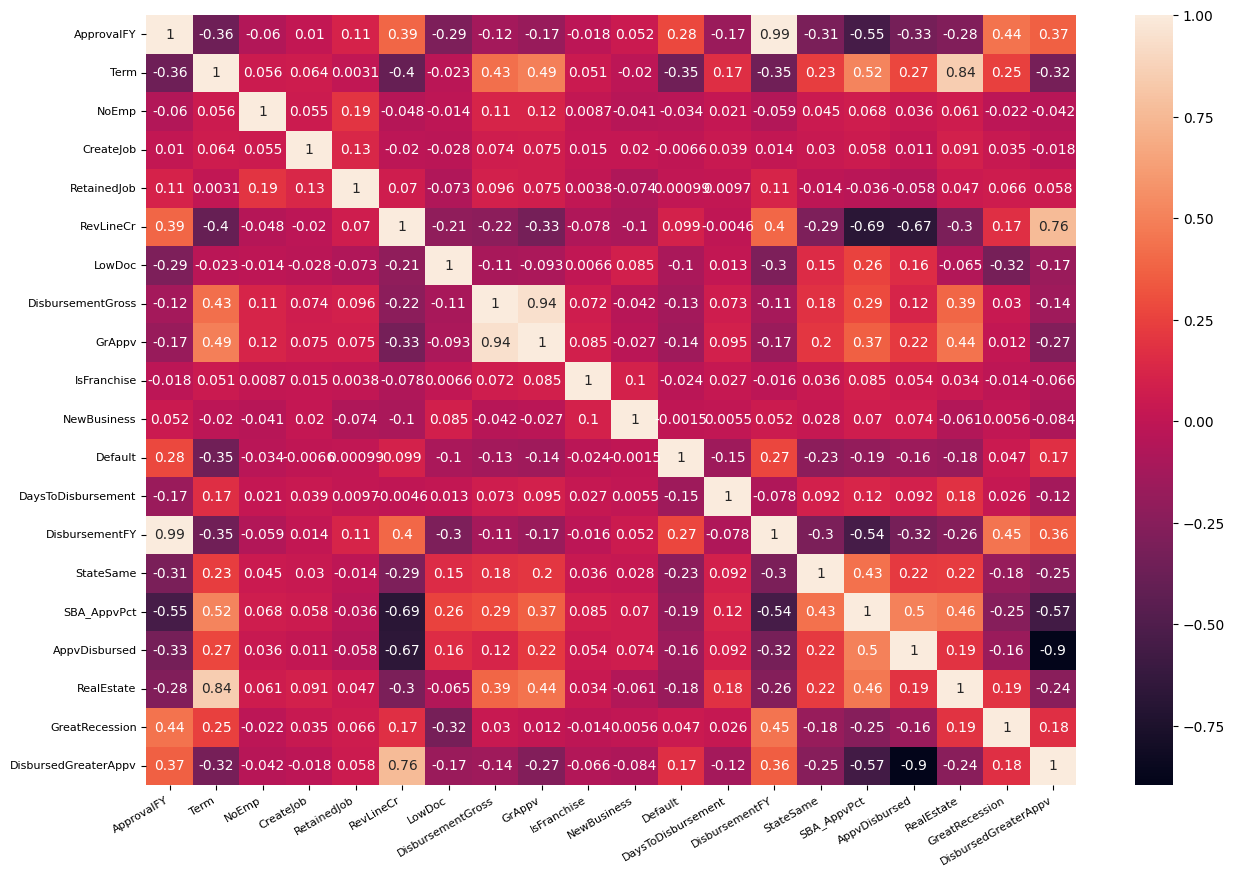

In [42]:
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['number'])

# Create Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, ax=cor_ax)

plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

Some notable correlations:

GrAppv & DisbursementGross, Positive - Makes sense that in most situations, the amount disbursed is close to what was approved

DisbursedGreaterAppv & AppvDisbursed, Negative - Also makes sense since when the disbursed amount is greater than approved, the disbursed amount is then not equal to the approved amount

RevLineCr & DisbursedGreaterAppv, Positive - Due to the nature of revolving lines of credit (think of it like a credit card for businesses where the business can draw funds with a limit, pays it off when able, and then draw more funds again), this makes sense that over time more funds are used then the limit set for the loan
DisbursementFY & ApprovalFY, Positive - More often than not, the funds will be disbursed in the same year they are approved

AppvDisbursed & RevLineCr, Negative - Typically, based on my experience underwriting loans as a Credit Analyst, the limit for a line of credit is lower than a term loan on average since the business can continually draw funds from the line of credit when needed after paying off the balance, which would explain the negative relationship.

SBA_AppvPct & RevLineCr, Negative - SBA lines of credit can still be eligible for guarantees, however the guarantee percentage is dependant on the size of the loan. Although this doesn't quite explain the negative relationship between SBA guarantee percentage and a loan being RevLineCr, what could is the type of SBA loan program used for the loan application. The most common used are the SBA 7(a) and SBA Express programs:

SBA 7(a) program: Provides an 85% guarantee on loan amounts up to 150,000 and a 75% guarantee on loan amounts over 150,000, but require more paperwork from the SBA and the eligibility decision is typically made by the SBA; Turn around time of 5-10 days

SBA Express: Max loan amount of 350,000 with a guarantee amount of 50%, however the forms required are the lender's own forms and the eligibility decision is made by the lender rather than the SBA; Turn time of about 36 hours

Although this dataset unfortunately doesn't contain information on the loan program used for each loan, my assumption is that most businesses elected to use the SBA Express program for revolving lines of credit because it's easier to get loan approval and the turn time is much quicker, meaning the loan guarantee amounts for revolving lines of credit would typically be less.

Okay, let's look at some graphs of the data. Some ideas that come to mind are:

    Total/Average disbursed loan amount by industry

    Average days to disbursement by industry

    Number of paid in full and defaulted loans by industry

    Number of paid in full and defaulted loans by ApprovalFY

    Number of paid in full and defaulted loans by State

    Percentage of defaulted loans backed by Real Estate

    Percentage of defaulted loans active during the Great Recession

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\3278643024.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)
C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\3278643024.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)


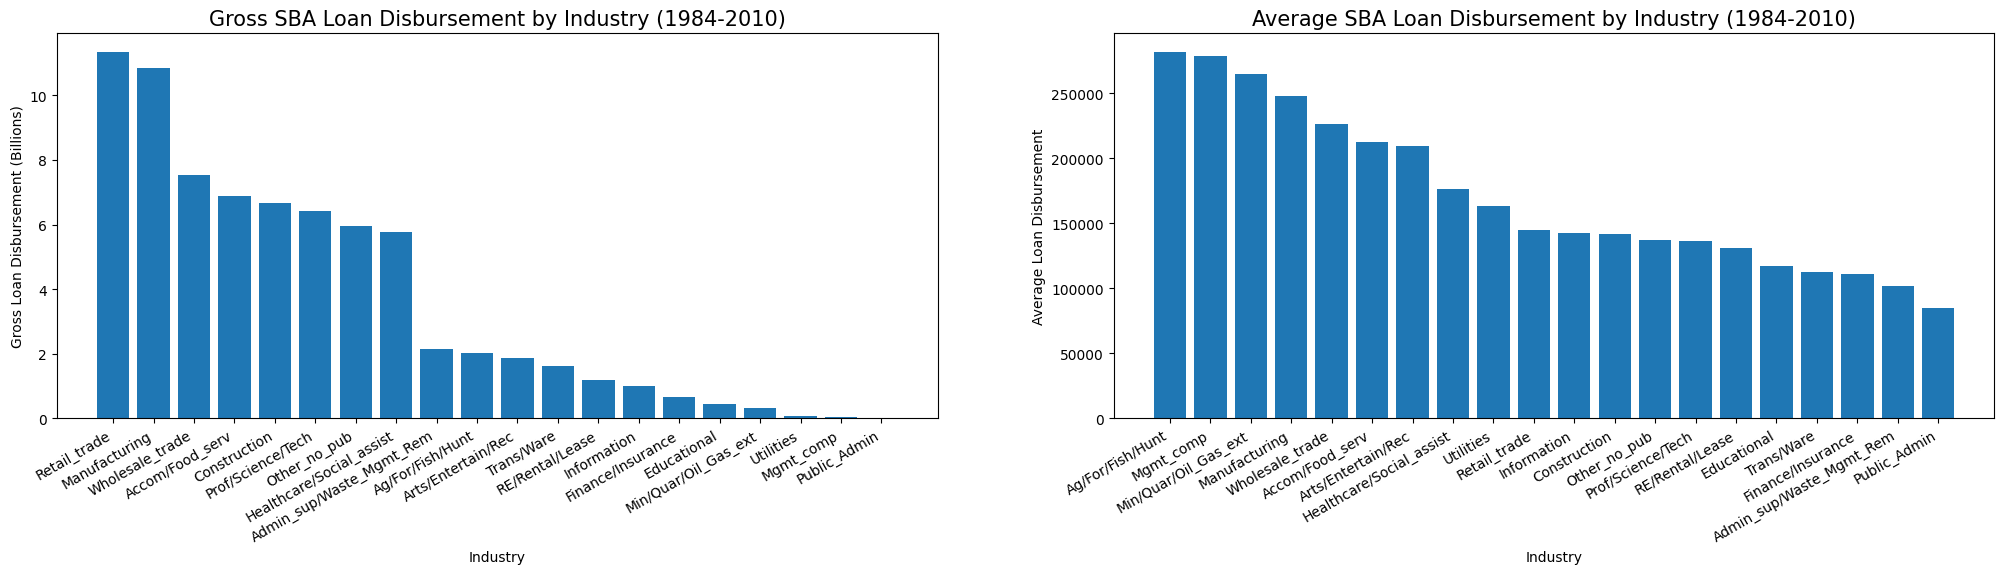

In [43]:
# Ensure 'DisbursementGross' is numeric
df['DisbursementGross'] = pd.to_numeric(df['DisbursementGross'], errors='coerce')

# Drop rows where 'DisbursementGross' is NaN (if conversion failed for some values)
df = df.dropna(subset=['DisbursementGross'])

# Group by Industry
industry_group = df.groupby('Industry')

# Aggregate total and average values, keeping only numeric columns
df_industrySum = industry_group.sum(numeric_only=True).sort_values('DisbursementGross', ascending=False)
df_industryAve = industry_group.mean(numeric_only=True).sort_values('DisbursementGross', ascending=False)

# Establish figure for side-by-side bar charts
fig = plt.figure(figsize=(25, 5))

# Add subplots
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# Bar chart 1 = Gross SBA Loan Disbursement by Industry
ax1.bar(df_industrySum.index, df_industrySum['DisbursementGross'] / 1e9)  # Convert to billions
ax1.set_xticklabels(df_industrySum.index, rotation=30, horizontalalignment='right', fontsize=10)
ax1.set_title('Gross SBA Loan Disbursement by Industry (1984-2010)', fontsize=15)
ax1.set_xlabel('Industry')
ax1.set_ylabel('Gross Loan Disbursement (Billions)')

# Bar chart 2 = Average SBA Loan Disbursement by Industry
ax2.bar(df_industryAve.index, df_industryAve['DisbursementGross'])
ax2.set_xticklabels(df_industryAve.index, rotation=30, horizontalalignment='right', fontsize=10)
ax2.set_title('Average SBA Loan Disbursement by Industry (1984-2010)', fontsize=15)
ax2.set_xlabel('Industry')
ax2.set_ylabel('Average Loan Disbursement')

plt.show()


Some notes:

Retail trade and Manufacturing industries had significantly more loan funds distributed to them during the sample period compared to other industries

Although the Agriculture, forestry, fishing and hunting, Mining, quarrying, and oil and gas extraction, and Management of companies and enterprises industries had a small amount of total loan funds distributed to them during this time relative to most other industries, they had the highest average loan amount compared to other industries; This suggests they had a small number of large loans

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\1288567138.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_industryAve['DaysToDisbursement'].sort_values(ascending=False).index, rotation=35,


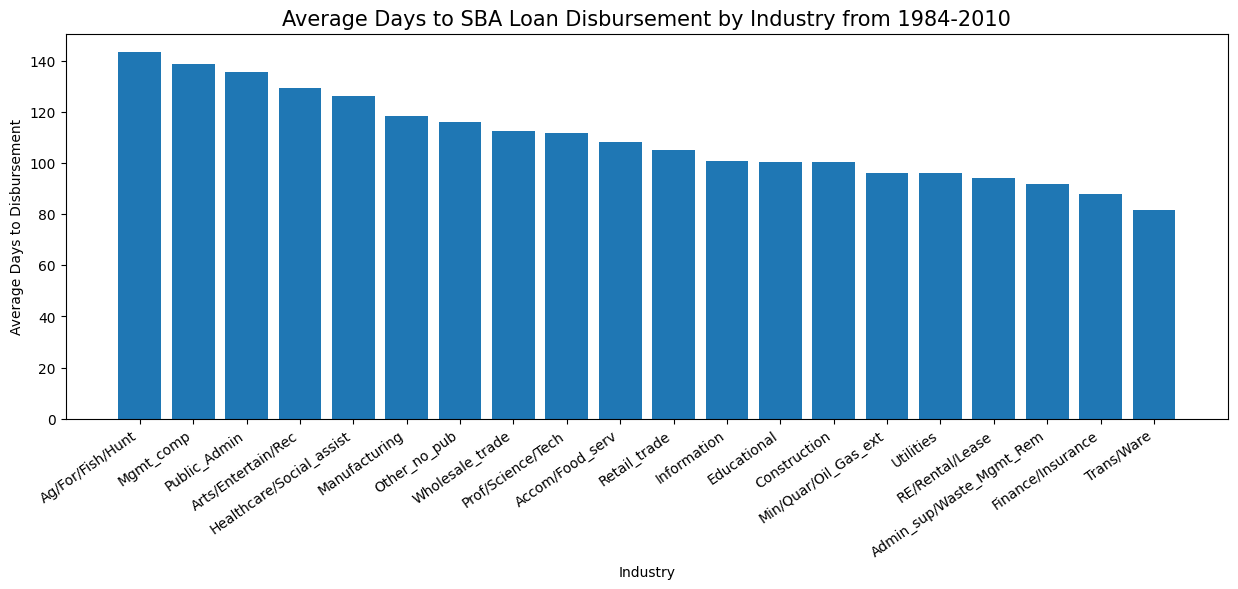

In [44]:
# Average days to disbursement by industry
fig2, ax = plt.subplots(figsize=(15, 5))

ax.bar(df_industryAve.index, df_industryAve['DaysToDisbursement'].sort_values(ascending=False))
ax.set_xticklabels(df_industryAve['DaysToDisbursement'].sort_values(ascending=False).index, rotation=35,
                   horizontalalignment='right', fontsize=10)

ax.set_title('Average Days to SBA Loan Disbursement by Industry from 1984-2010', fontsize=15)
ax.set_xlabel('Industry')
ax.set_ylabel('Average Days to Disbursement')

plt.show()

Notes:

Interestingly, some of the industries with the highest average loan amount also had the highest number of days to disbursement of funds, including the Agriculture, forestry, fishing and hunting, and Management of companies and enterprises industries

C:\Users\Vedant\AppData\Local\Temp\ipykernel_7236\3595781109.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1a.set_xticklabels(df.groupby(['Industry', 'Default'])['Industry'].count().unstack('Default').index,


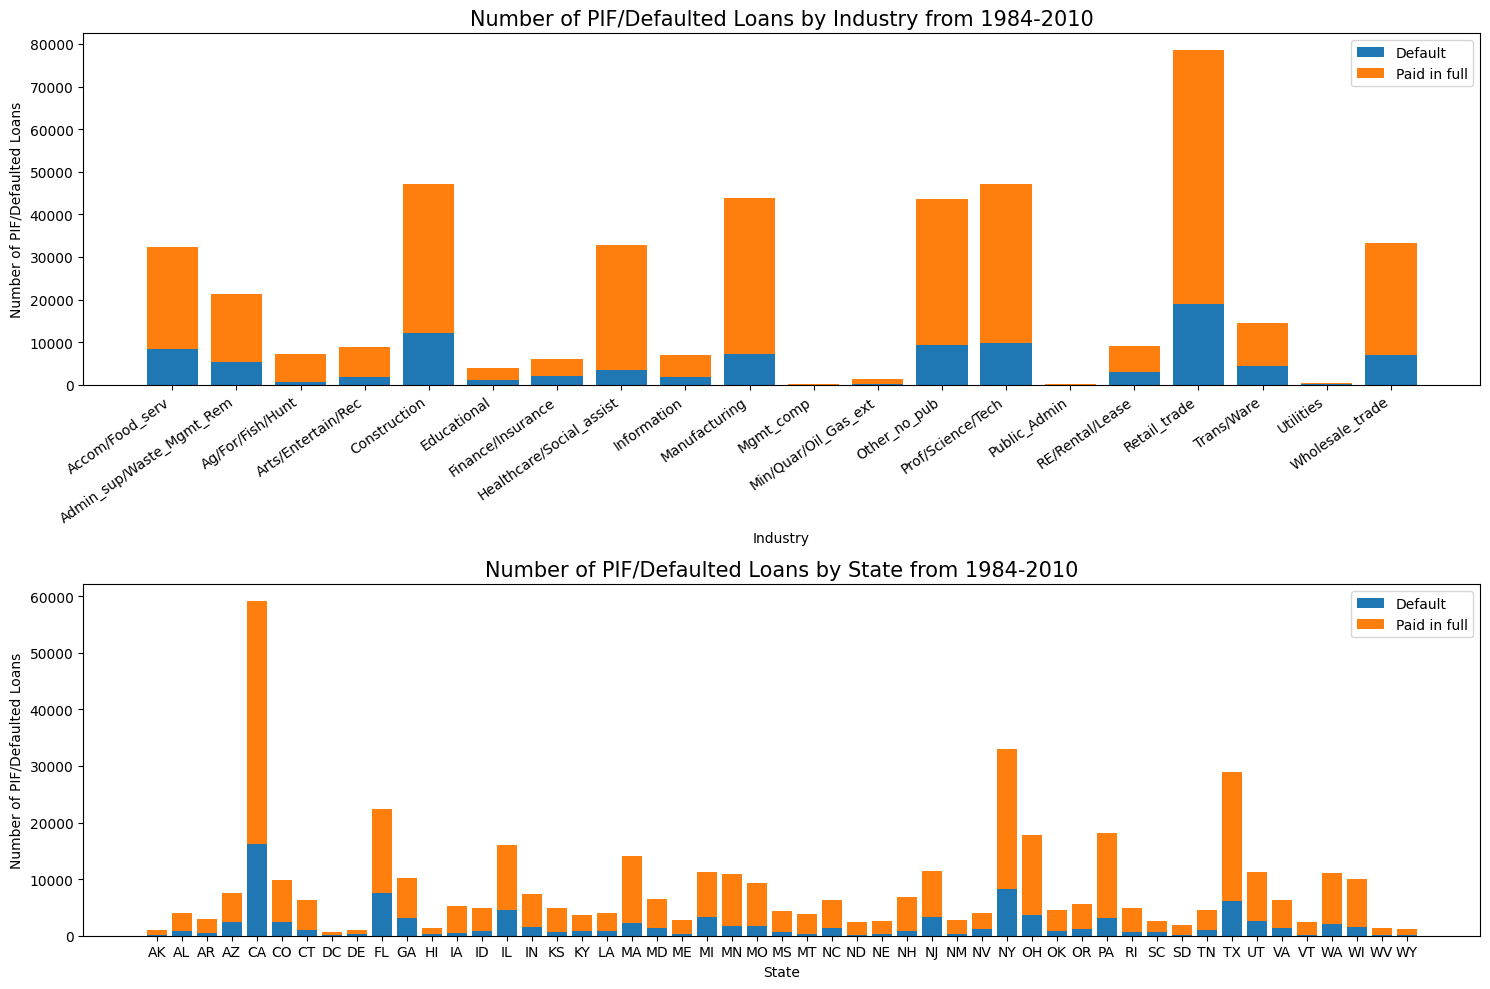

In [45]:
# Paid in full and defaulted loans
fig3 = plt.figure(figsize=(15, 10))

ax1a = plt.subplot(2, 1, 1)
ax2a = plt.subplot(2, 1, 2)

# Function for creating stacked bar charts grouped by desired column
# df = original data frame, col = x-axis grouping, stack_col = column to show stacked values
# Essentially acts as a stacked histogram when stack_col is a flag variable
def stacked_setup(df, col, axes, stack_col='Default'):
    data = df.groupby([col, stack_col])[col].count().unstack(stack_col)
    data.fillna(0)

    axes.bar(data.index, data[1], label='Default')
    axes.bar(data.index, data[0], bottom=data[1], label='Paid in full')


# Number of Paid in full and defaulted loans by industry
stacked_setup(df=df, col='Industry', axes=ax1a)
ax1a.set_xticklabels(df.groupby(['Industry', 'Default'])['Industry'].count().unstack('Default').index,
                     rotation=35, horizontalalignment='right', fontsize=10)

ax1a.set_title('Number of PIF/Defaulted Loans by Industry from 1984-2010', fontsize=15)
ax1a.set_xlabel('Industry')
ax1a.set_ylabel('Number of PIF/Defaulted Loans')
ax1a.legend()

# Number of Paid in full and defaulted loans by State
stacked_setup(df=df, col='State', axes=ax2a)

ax2a.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax2a.set_xlabel('State')
ax2a.set_ylabel('Number of PIF/Defaulted Loans')
ax2a.legend()

plt.tight_layout()
plt.show()

In [46]:
# Check Default percentage by Industry
def_ind = df.groupby(['Industry', 'Default'])['Industry'].count().unstack('Default')
def_ind['Def_Percent'] = def_ind[1]/(def_ind[1] + def_ind[0])
def_ind

Default,0,1,Def_Percent
Industry,,,
Accom/Food_serv,23936,8381,0.259337
Admin_sup/Waste_Mgmt_Rem,15774,5427,0.255978
Ag/For/Fish/Hunt,6536,657,0.091339
Arts/Entertain/Rec,6976,1917,0.215563
Construction,34999,12048,0.256084
Educational,2750,1070,0.280105
Finance/Insurance,3984,2093,0.344413
Healthcare/Social_assist,29192,3571,0.108995
Information,5222,1830,0.259501


In [47]:
# Check Default percentage by State
def_state = df.groupby(['State', 'Default'])['State'].count().unstack('Default')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state

Default,0,1,Def_Percent
State,,,
AK,979,94,0.087605
AL,3192,805,0.201401
AR,2414,528,0.179470
AZ,5119,2473,0.325738
CA,42983,16138,0.272966
CO,7439,2349,0.239988
CT,5328,1064,0.166458
DC,567,157,0.216851
DE,841,246,0.226311


Notes:

Industries with the highest number of loans during sample period: Retail trade (78,554), Professional, scientific and technical services (47,081) and Construction (47,047)

Industries with the highest Default percentage: Finance and Insurance (34.4%), Real Estate and rental leasing (33.8%) and Transportation and warehousing (30.7%)

States with the highest number of loans during sample period: California (59,121), New York (33,059) and Texas (28,941)

State with the highest Default percentage: Florida (33.8%), Arizona (32.6%) and Nevada (31.6%)

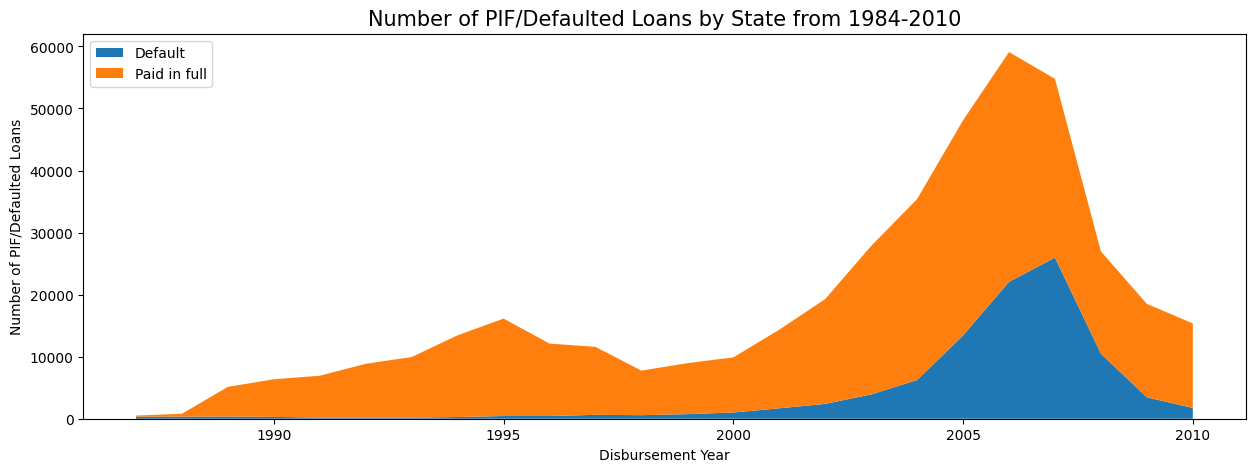

In [48]:
# Paid in full and Defaulted loans by DisbursementFY
# Decided to use a stacked area chart here since it's time series data
fig4, ax4 = plt.subplots(figsize=(15, 5))

stack_data = df.groupby(['DisbursementFY', 'Default'])['DisbursementFY'].count().unstack('Default')
x = stack_data.index
y = [stack_data[1], stack_data[0]]

ax4.stackplot(x, y, labels=['Default', 'Paid in full'])
ax4.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax4.set_xlabel('Disbursement Year')
ax4.set_ylabel('Number of PIF/Defaulted Loans')
ax4.legend(loc='upper left')

plt.show()

There is a clear increase in loan volume leading up to the peak of the Great Recession, with a subsequent drop in loan volume immediately following that time. Looking at the graph, it appears the default rate of loans increased during that time as well.

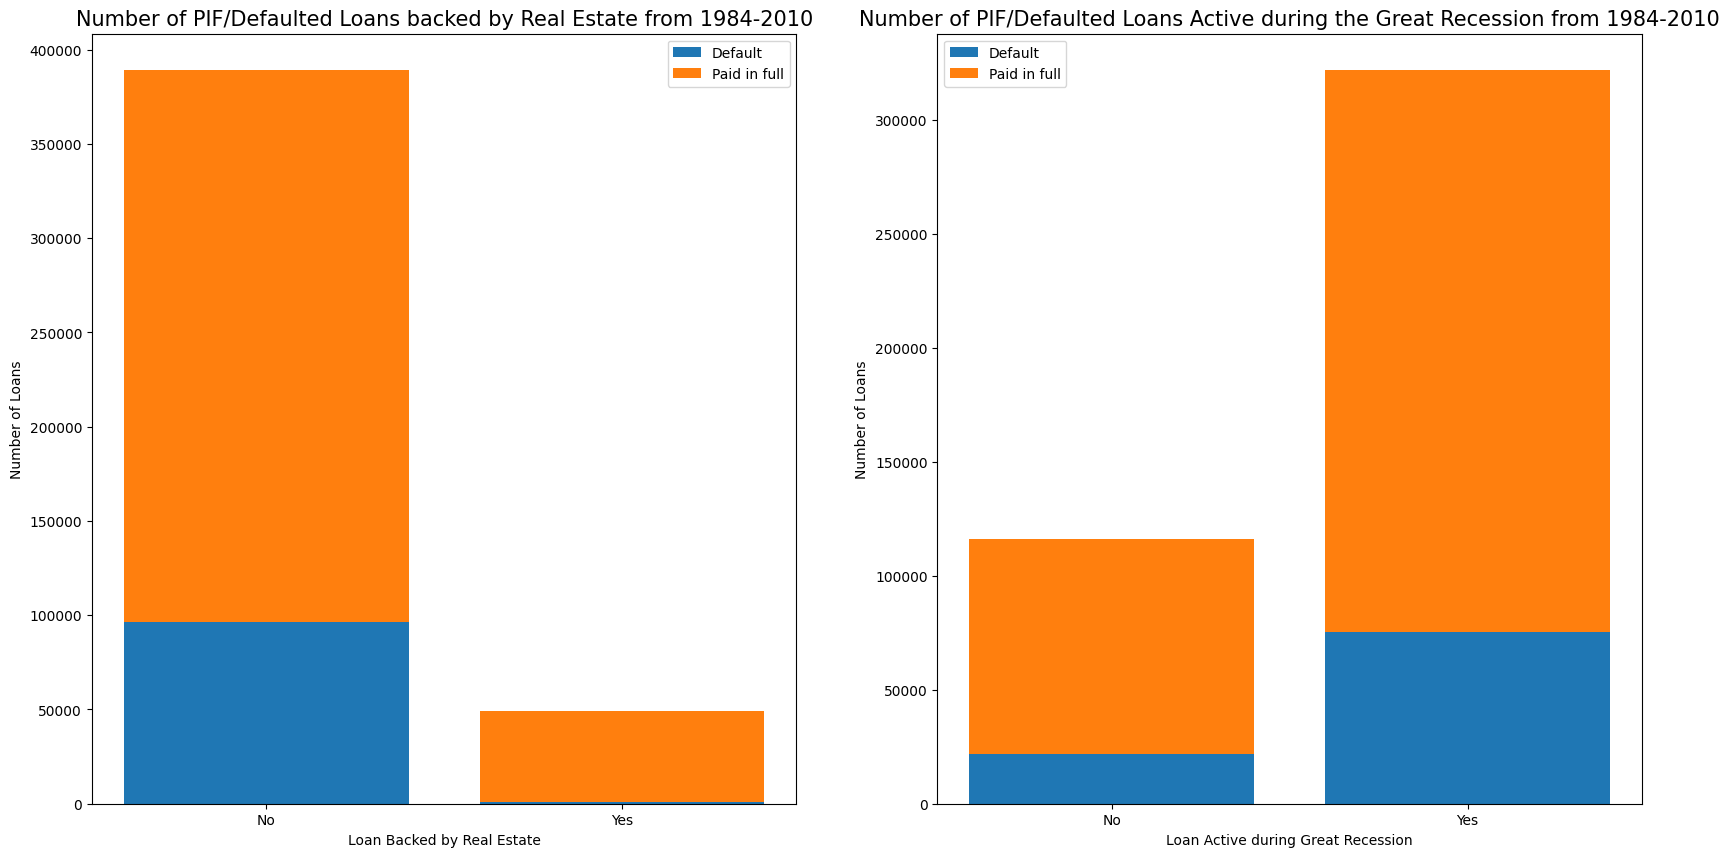

In [49]:
# Paid in full and defaulted loans backed by Real Estate
fig5 = plt.figure(figsize=(20, 10))

ax1b = fig5.add_subplot(1, 2, 1)
ax2b = fig5.add_subplot(1, 2, 2)

stacked_setup(df=df, col='RealEstate', axes=ax1b)
ax1b.set_xticks(df.groupby(['RealEstate', 'Default'])['RealEstate'].count().unstack('Default').index)
ax1b.set_xticklabels(labels=['No', 'Yes'])

ax1b.set_title('Number of PIF/Defaulted Loans backed by Real Estate from 1984-2010', fontsize=15)
ax1b.set_xlabel('Loan Backed by Real Estate')
ax1b.set_ylabel('Number of Loans')
ax1b.legend()

# Paid in full and defaulted loans active during the Great Recession
stacked_setup(df=df, col='GreatRecession', axes=ax2b)
ax2b.set_xticks(df.groupby(['GreatRecession', 'Default'])['GreatRecession'].count().unstack('Default').index)
ax2b.set_xticklabels(labels=['No', 'Yes'])

ax2b.set_title('Number of PIF/Defaulted Loans Active during the Great Recession from 1984-2010', fontsize=15)
ax2b.set_xlabel('Loan Active during Great Recession')
ax2b.set_ylabel('Number of Loans')
ax2b.legend()

plt.show()

In [50]:
# Check Default percentage for loans backed by Real Estate
def_re = df.groupby(['RealEstate', 'Default'])['RealEstate'].count().unstack('Default')
def_re['Def_Percent'] = def_re[1]/(def_re[1] + def_re[0])
def_re

Default,0,1,Def_Percent
RealEstate,,,
0,292446,96587,0.248275
1,48371,686,0.013984


In [51]:
# Check Default percentage for loans active during the Great Recession
def_gr = df.groupby(['GreatRecession', 'Default'])['GreatRecession'].count().unstack('Default')
def_gr['Def_Percent'] = def_gr[1]/(def_gr[1] + def_gr[0])
def_gr

Default,0,1,Def_Percent
GreatRecession,,,
0,94279,22030,0.189409
1,246538,75243,0.233833


The volume of loans backed by real estate was much less than those not backed by real estate (which makes sense that most people aren't willing to take on that much risk), however the default rate is also much less for loans backed by real estate. This is likely because the people and businesses who have their loans backed by real estate have much more skin in the game so they're more willing to do what it takes to pay the debt.

I thought loans active during the Great Recession would have a noticeably higher default rate than those not active during that time. My assumption is this difference would be more apparent if the focus was on loans disbursed in the few years leading up to the Great Recession, perhaps beginning in 2004 or 2005.

In [52]:
df.dtypes

State                    object
BankState                object
ApprovalFY                int64
Term                      int64
NoEmp                     int64
CreateJob                 int64
RetainedJob               int64
UrbanRural               object
RevLineCr                 int64
LowDoc                    int64
DisbursementGross         int64
GrAppv                    int64
Industry                 object
IsFranchise               int64
NewBusiness               int64
Default                   int64
DaysToDisbursement        int64
DisbursementFY            int64
StateSame                 int64
SBA_AppvPct             float64
AppvDisbursed             int64
RealEstate                int64
GreatRecession            int64
DisbursedGreaterAppv      int64
dtype: object

# Modeling

Now that I've done some more exploring of the data, I think it's about time to experiment with some modeling. I know I want to try a Logistic Regression model, and I'd like to try an XGBoost model as well as I know this is currently a popular model to use in Kaggle competitions and generally performs pretty well.

Something I want to keep in mind when evaluating model performance is that a good accuracy doesn't necessarily mean the model performed well. We need to consider metrics like the precision, recall, and F1-score to ensure we are evaluating model performance based on the 'cost' of the outcomes. For example in this situation, it's better if we predict a loan will default and it doesn't than if we predict a loan will be paid in full and ends up in default. In other words, we want a model that minimizes the number of false negatives (since a 1 in the Default field signifies a 'positive' value in this case). Essentially we want a model that predicts the correct outcome most of the time, but when it gets it wrong it's not as bad.

In [53]:
# One-hot encode categorical data
df = pd.get_dummies(df)

df.head()

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,IsFranchise,NewBusiness,Default,DaysToDisbursement,DisbursementFY,StateSame,SBA_AppvPct,AppvDisbursed,RealEstate,GreatRecession,DisbursedGreaterAppv,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,BankState_AK,BankState_AL,BankState_AR,BankState_AZ,BankState_CA,BankState_CO,BankState_CT,BankState_DC,BankState_DE,BankState_FL,BankState_GA,BankState_GU,BankState_HI,BankState_IA,BankState_ID,BankState_IL,BankState_IN,BankState_KS,BankState_KY,BankState_LA,BankState_MA,BankState_MD,BankState_ME,BankState_MI,BankState_MN,BankState_MO,BankState_MS,BankState_MT,BankState_NC,BankState_ND,BankState_NE,BankState_NH,BankState_NJ,BankState_NM,BankState_NV,BankState_NY,BankState_OH,BankState_OK,BankState_OR,BankState_PA,BankState_PR,BankState_RI,BankState_SC,BankState_SD,BankState_TN,BankState_TX,BankState_UT,BankState_VA,BankState_VT,BankState_WA,BankState_WI,BankState_WV,BankState_WY,UrbanRural_0,UrbanRural_1,UrbanRural_2,Industry_Accom/Food_serv,Industry_Admin_sup/Waste_Mgmt_Rem,Industry_Ag/For/Fish/Hunt,Industry_Arts/Entertain/Rec,Industry_Construction,Industry_Educational,Industry_Finance/Insurance,Industry_Healthcare/Social_assist,Industry_Information,Industry_Manufacturing,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
0,1997,84,4,0,0,0,1,60000,60000,0,1,0,730,1999,0,0.80,1,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,1997,60,2,0,0,0,1,40000,40000,0,1,0,92,1997,1,0.80,1,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1997,180,7,0,0,0,0,287000,287000,0,0,0,306,1997,1,0.75,1,0,1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [54]:
df.shape

(438090, 147)

In [55]:
# # Define the sample size
# sample_size = 150000

# # Randomly sample 150,000 records
# df_sampled = df.sample(n=sample_size, random_state=42)  # Set random_state for reproducibility

# # Define the file path
# csv_filename = "sampled_dataset_before_model.csv"

# # Save the sampled DataFrame to CSV
# df_sampled.to_csv(csv_filename, index=False)

In [56]:
# Establish target and feature fields
y = df['Default']
X = df.drop('Default', axis=1)

# Scale the feature values prior to modeling
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

In [57]:
# Initialize model
log_reg = LogisticRegression(random_state=2)

# Train the model and make predictions
log_reg.fit(X_train, y_train)
y_logpred = log_reg.predict(X_val)

# Print the results
print(classification_report(y_val, y_logpred, digits=3))

              precision    recall  f1-score   support

           0      0.895     0.951     0.922     85120
           1      0.782     0.609     0.685     24403

    accuracy                          0.875    109523
   macro avg      0.839     0.780     0.804    109523
weighted avg      0.870     0.875     0.869    109523



In [58]:
# Save model and scaler
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

print("Logistic Regression model saved successfully!")

Logistic Regression model saved successfully!


We can see here that with the Logistic Regression model, we have a decent accuracy at 87.5%, however the F1-score of 68.4% for defaulted loans does not seem very promising. The precision suggests that the model is correct 78.2% of the time when the loan defaults, and the recall suggests that the model identifies 60.8% of defaulted loans correctly. That means that 39.2% of loans that defaulted were incorrectly classified as loans that would be paid in full, which is NOT very good.

Let's see if the XGBoost model can do any better.

In [59]:
xgboost = XGBClassifier(random_state=2)

xgboost.fit(X_train, y_train)
y_xgbpred = xgboost.predict(X_val)

# Print the results
print(classification_report(y_val, y_xgbpred, digits=3))

              precision    recall  f1-score   support

           0      0.966     0.976     0.971     85120
           1      0.912     0.881     0.896     24403

    accuracy                          0.955    109523
   macro avg      0.939     0.929     0.934    109523
weighted avg      0.954     0.955     0.954    109523



This is MUCH better across the board! Not only do we have a general accuracy of 95.6%, but also the precision, recall and F1-score are all improved by quite a bit. I might go back and try tweaking some of the hyperparameters later, but for now I'm satisfied with this. Let's take a look at some of the most important features.

In [60]:
# List the importance of each feature
for name, importance in sorted(zip(X.columns, xgboost.feature_importances_)):
    print(name, "=", importance)

ApprovalFY = 0.04994284
AppvDisbursed = 0.019185752
BankState_AK = 0.0
BankState_AL = 0.004199583
BankState_AR = 0.0034241495
BankState_AZ = 0.00153792
BankState_CA = 0.029228346
BankState_CO = 0.0
BankState_CT = 0.0022840558
BankState_DC = 0.0016904495
BankState_DE = 0.036831163
BankState_FL = 0.0069297613
BankState_GA = 0.011216038
BankState_GU = 0.0
BankState_HI = 0.0030518847
BankState_IA = 0.0033335139
BankState_ID = 0.0030732644
BankState_IL = 0.017001692
BankState_IN = 0.005964907
BankState_KS = 0.0050184242
BankState_KY = 0.0034222556
BankState_LA = 0.0022245534
BankState_MA = 0.00022068407
BankState_MD = 0.0071735536
BankState_ME = 0.0
BankState_MI = 0.002004915
BankState_MN = 0.004968404
BankState_MO = 0.0046054563
BankState_MS = 0.0046998886
BankState_MT = 0.008224561
BankState_NC = 0.03738481
BankState_ND = 0.0012527718
BankState_NE = 0.0032178687
BankState_NH = 0.0
BankState_NJ = 0.0028276648
BankState_NM = 0.0019918284
BankState_NV = 0.0016990581
BankState_NY = 0.00420169

Some interesting notes from the list of feature importances:

The top five features by level of importance are Term, StateSame, ApprovalFY, UrbanRural_1 (Urban), and BankState_NC in that order
Industry feature importance - Highest: Healthcare/Social_assist, Lowest: Mgmt_comp, Public_Admin and Utilities
A loan being backed by Real Estate surprisingly had zero feature importance; I had also anticipated a loan being active during the Great Recession being in the top five most important features
Whether or not a business applying for an SBA loan is a new business did not seem to be very important when determining if the loan would default
There's plenty more I could dig into in regard to the feature importances, but these are a few of the things I noticed right away, some of which I didn't expect. One thing I wanted to try was seeing if reducing the number of features used to the most important ones would have a positive impact on the model performance, since the current model has a high level of dimensionality.

In [61]:
# Build pipeling for feature selection and modeling; SelectKBest defaults to top 10 features
xgb_featimp = XGBClassifier(random_state=2)

pipe = Pipeline(steps=[
    ('feature_selection', SelectKBest()),
    ('model', xgb_featimp)
])

pipe.fit(X_train, y_train)
y_featimppred = pipe.predict(X_val)

print(classification_report(y_val, y_featimppred, digits=3))

              precision    recall  f1-score   support

           0      0.960     0.967     0.963     85120
           1      0.882     0.859     0.870     24403

    accuracy                          0.943    109523
   macro avg      0.921     0.913     0.917    109523
weighted avg      0.942     0.943     0.943    109523



In [62]:
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_featimp, f)

print("XGBoost model saved successfully!")

XGBoost model saved successfully!


It looks like reducing the number of features, and thereby dimensionality of the data, didn't affect the results too drastically. In fact, this model would likely perform better in a real world test because it is far more generalized. Let's take a look at what features were actually selected then.

In [63]:
# List the importance of each feature
for name, importance in sorted(zip(X.columns, xgb_featimp.feature_importances_)):
    print(name, "=", importance)

ApprovalFY = 0.14124948
CreateJob = 0.14041124
DisbursementGross = 0.04258607
GrAppv = 0.06441042
IsFranchise = 0.061474115
LowDoc = 0.0
NoEmp = 0.042860843
RetainedJob = 0.041327924
RevLineCr = 0.04420359
Term = 0.4214763


Looks like the Term is still the most important by far, but the top five features have certainly changed! Job creation played a much larger role in this model, which is interesting to see. Perhaps onboarding new employees is more expensive, which puts a strain on the business's bottom line and therefore ability to repay the loan. I also find it interesting that the loans which were part of the Low Doc program was selected as a most important feature, however it apparently shows zero importance here.

# Conclusion and next steps

According to this analysis, the factor that contributes the most to whether or not a loan goes into default is the length of the term of the loan, where the longer the term is the higher the chance that the loan will go into default. Further analysis could be done in this area, and I may revisit this at a later date and see if binning the loan term length will prove more valuable in modeling. The term of the loan is typically tied to the size of the loan, which was also selected as one of the most important features in determining whether or not a loan will be paid in full. There are a number of other factors that I was unable to consider for this analysis that I believe would be beneficial, such as which of the SBA loan programs each loan fell under. I could certainly go back and address some of the existing outliers and skewness in some of the features, and would also consider looking at other types of models and will be interested to play with the hyperparameters of the models when I look at this again in the future.

Despite all of the data provided here, there is something else that isn't captured in this data that is arguably the most important and relevant factor in determining the ability of a business to repay the loan: the business owner(s) and the business operations themselves! Although the industry does have some weight in this aspect, the data doesn't include the cash flow of each business, working capital, existing debt they had prior to applying for the SBA loan, etc. The data also can't capture the personality, attitude and drive of a business owner to make the business successful. A business can be very successful, but at the end of the day if the owner doesn't want to pay the loan they won't. It's a sad truth, but it happens more often than you'd think.

If you've read this far, thanks for taking the time to look at my analysis! As mentioned, I will likely revisit this to dig deeper as I sharpen my skillset. I certainly learned a lot working through this, and I hope you're able to take something away from this as well.